# Explore here

In [1]:
# Basics
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Analytics for time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Models
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Utils
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Get data
ts = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
ts

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [4]:
# Convert date column to datetime type
ts["date"] = pd.to_datetime(ts["date"])
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    366 non-null    datetime64[ns]
 1   sales   366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [5]:
# Redefine series index
ts = ts.set_index("date")
ts

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


In [6]:
# Ensure chronology of the series 
ts = ts.sort_index()
ts

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


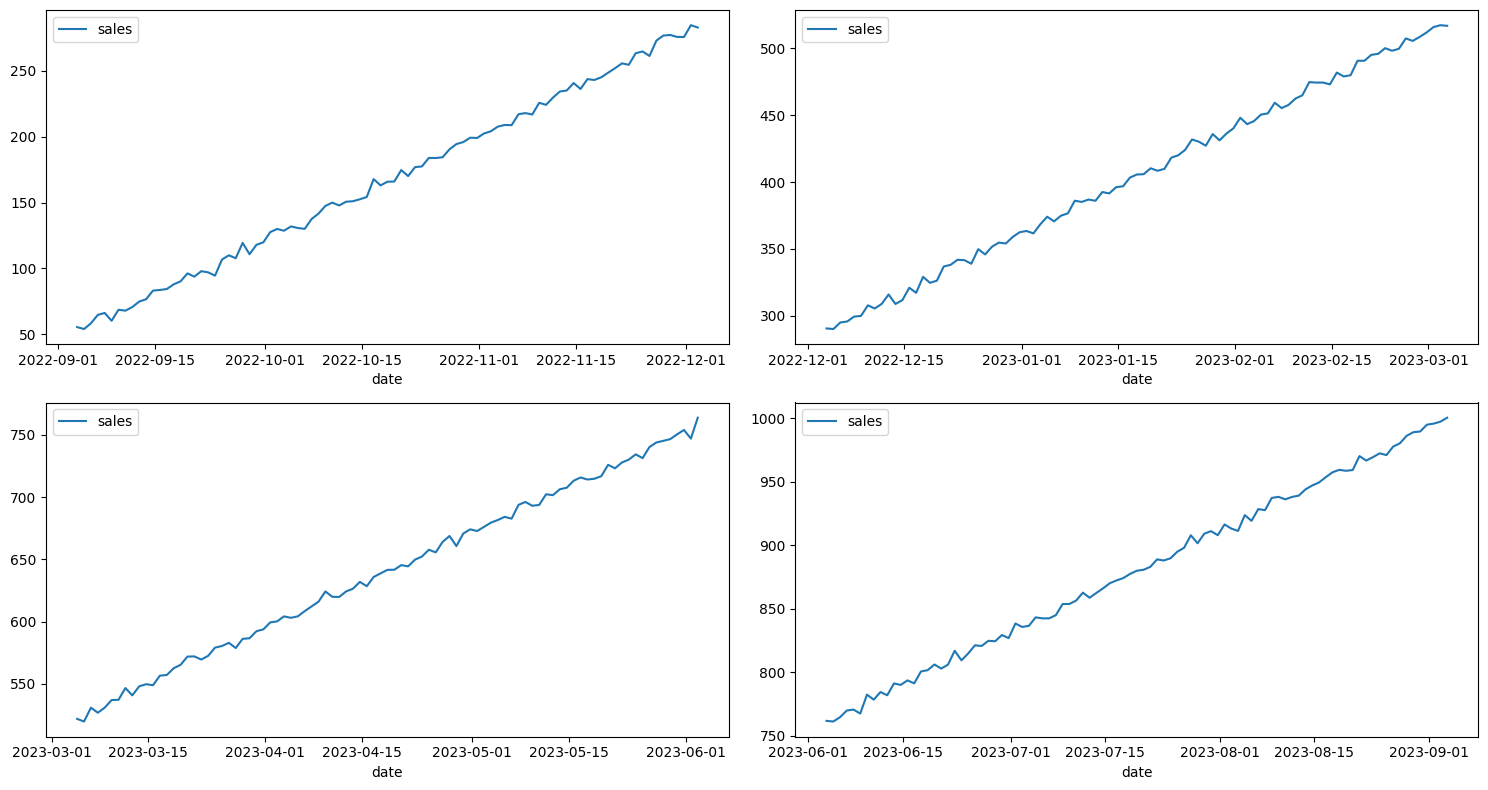

In [7]:
fig, axis = plt.subplots(2,2,figsize = (15, 8))

sns.lineplot(ax=axis[0,0], data = ts.iloc[0:91])
sns.lineplot(ax=axis[0,1], data = ts.iloc[91:182])
sns.lineplot(ax=axis[1,0], data = ts.iloc[182:273])
sns.lineplot(ax=axis[1,1], data = ts.iloc[273:])

plt.tight_layout()

plt.show()

We plotted the series in 4 plots, seeking to visually capture seasonal patterns. It clearly has an upward trend, and no repeating patterns are visible over time. We will use period 7 for our decomposition, looking for any weekly patterns, and an additive model, since seasonal patterns remain constant.

In [8]:
decomposition = seasonal_decompose(ts, model="additive", period=7)
decomposition

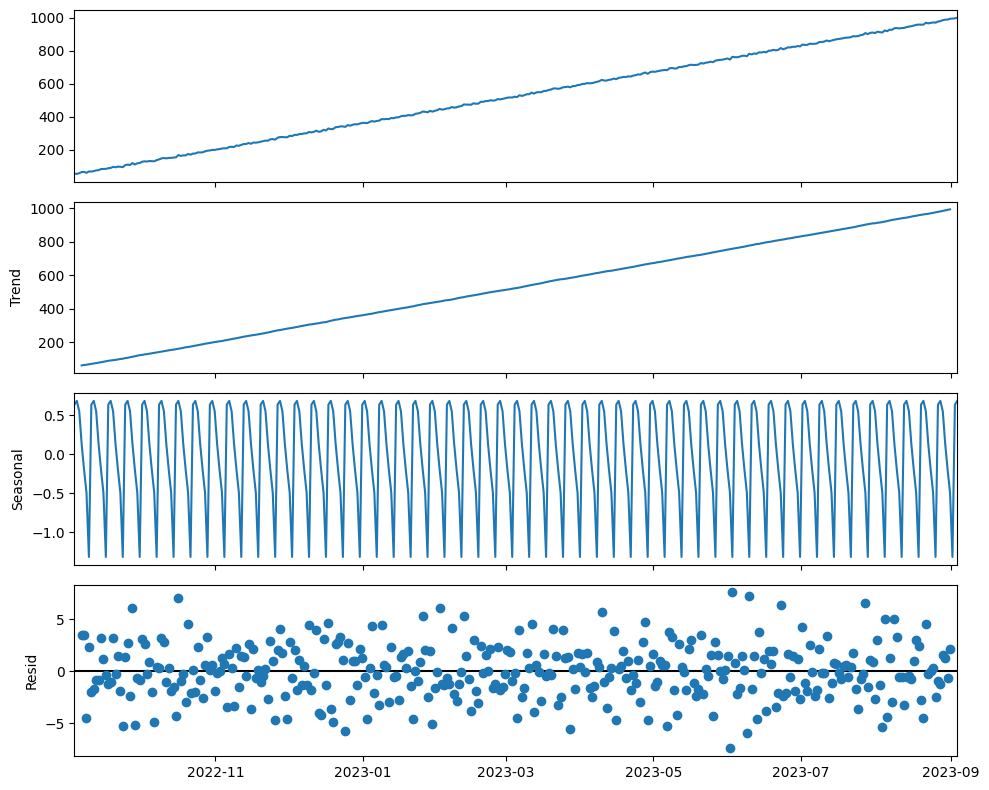

In [ ]:
# Graficar los componentes
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

Graphic Analysis
- Clear and fairly constant upward trend
- 7-day clear pattern
- Scattered residuals with no clear pattern

In [12]:
# Search for stationarity
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

In [13]:
test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

p-value is greater than 0.05, this means that our null hypothesis will be rejected and we will take this series as non-stationary

In [14]:
ts_diff = ts.copy()

In [15]:
# Differentiate the series to remove trend
ts_diff['sales'] = ts_diff['sales'].diff()
ts_diff = ts_diff.dropna()

In [16]:
test_stationarity(ts_diff)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

p-value less than 0.05, our differenced series is stationary with a single differentiation

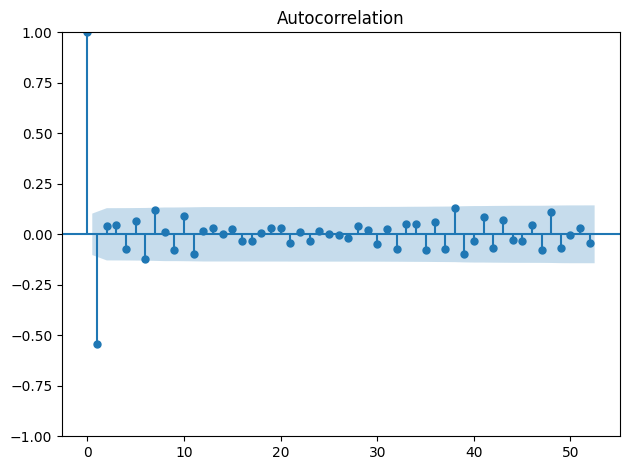

In [23]:
# Graficar ACF
plot_acf(ts_diff, lags=52) # Cada lag una semana (datos de un año)
plt.tight_layout()
plt.show()

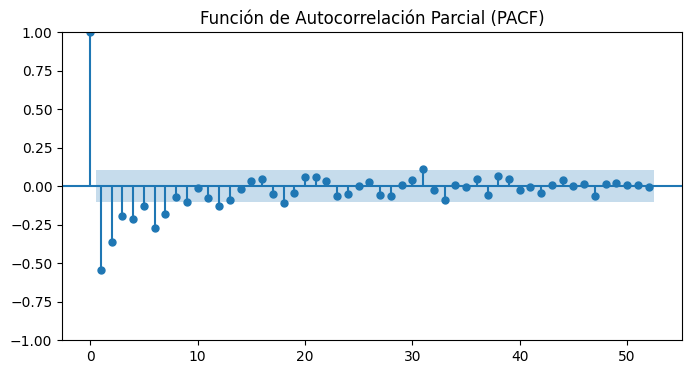

In [24]:
# Graficar PACF
plt.figure(figsize=(8, 4))
plot_pacf(ts_diff, lags=52, ax=plt.gca())
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.show()

Parameter selection:

- d=1 because the original series required differentiation to achieve stationarity
- p=1 was determined by the presence of a significant spike in lag 1 of the PACF of the differentiated series that then cuts
- q=1 was included due to the presence of a significant spike in lag 1 of the ACF of the differentiated series

In [74]:
p = 1
d = 1
q = 1

train = ts[:-30]
test = ts[-30:]

modelo_arima = ARIMA(train, order=(p,d,q))

resultado_arima = modelo_arima.fit()

In [78]:
predicciones = resultado_arima.predict(start=len(train), end=len(train)+30)
predicciones

2023-08-05 17:10:08.079328     926.307238
2023-08-06 17:10:08.079328     928.877708
2023-08-07 17:10:08.079328     931.448178
2023-08-08 17:10:08.079328     934.018647
2023-08-09 17:10:08.079328     936.589116
2023-08-10 17:10:08.079328     939.159585
2023-08-11 17:10:08.079328     941.730053
2023-08-12 17:10:08.079328     944.300520
2023-08-13 17:10:08.079328     946.870987
2023-08-14 17:10:08.079328     949.441454
2023-08-15 17:10:08.079328     952.011920
2023-08-16 17:10:08.079328     954.582385
2023-08-17 17:10:08.079328     957.152850
2023-08-18 17:10:08.079328     959.723315
2023-08-19 17:10:08.079328     962.293779
2023-08-20 17:10:08.079328     964.864243
2023-08-21 17:10:08.079328     967.434706
2023-08-22 17:10:08.079328     970.005169
2023-08-23 17:10:08.079328     972.575631
2023-08-24 17:10:08.079328     975.146093
2023-08-25 17:10:08.079328     977.716554
2023-08-26 17:10:08.079328     980.287015
2023-08-27 17:10:08.079328     982.857476
2023-08-28 17:10:08.079328     985

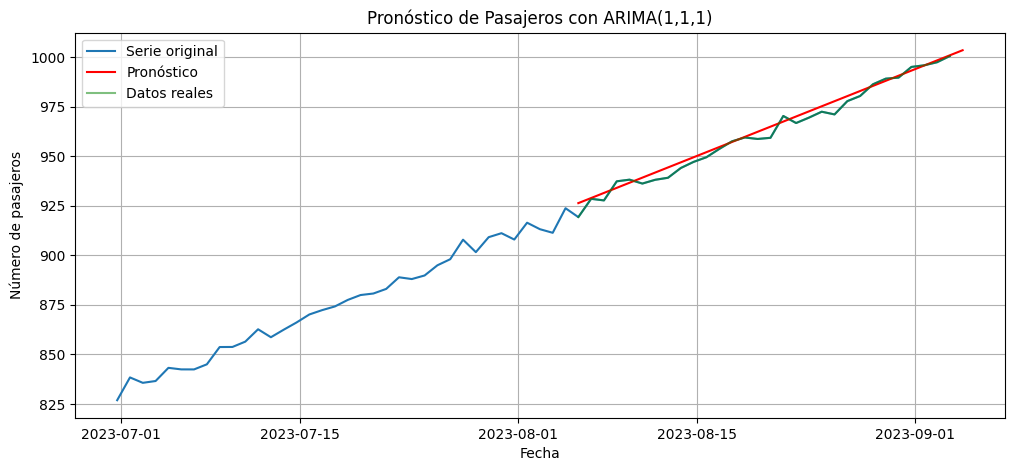

In [83]:
# Graficar pronóstico
plt.figure(figsize=(12,5))
plt.plot(ts[300:], label='Serie original')
plt.plot(predicciones, label='Pronóstico', color='red')
plt.plot(test, label="Datos reales", color="green", alpha=0.5)
plt.title("Pronóstico de Pasajeros con ARIMA(1,1,1)")
plt.xlabel("Fecha")
plt.ylabel("Número de pasajeros")
plt.legend()
plt.grid(True)
plt.show()

In [87]:
model = auto_arima(train, seasonal = True, trace = True, m = 1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1698.396, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1933.617, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1820.331, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1696.166, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2035.035, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1695.455, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1697.358, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1700.165, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1695.371, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1697.342, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1994.505, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.977 seconds


In [88]:
forecast = model.predict(30)
forecast

2023-08-05 17:10:08.079328    923.540627
2023-08-06 17:10:08.079328    926.325814
2023-08-07 17:10:08.079328    928.921351
2023-08-08 17:10:08.079328    931.516887
2023-08-09 17:10:08.079328    934.112424
2023-08-10 17:10:08.079328    936.707960
2023-08-11 17:10:08.079328    939.303497
2023-08-12 17:10:08.079328    941.899034
2023-08-13 17:10:08.079328    944.494570
2023-08-14 17:10:08.079328    947.090107
2023-08-15 17:10:08.079328    949.685643
2023-08-16 17:10:08.079328    952.281180
2023-08-17 17:10:08.079328    954.876716
2023-08-18 17:10:08.079328    957.472253
2023-08-19 17:10:08.079328    960.067789
2023-08-20 17:10:08.079328    962.663326
2023-08-21 17:10:08.079328    965.258863
2023-08-22 17:10:08.079328    967.854399
2023-08-23 17:10:08.079328    970.449936
2023-08-24 17:10:08.079328    973.045472
2023-08-25 17:10:08.079328    975.641009
2023-08-26 17:10:08.079328    978.236545
2023-08-27 17:10:08.079328    980.832082
2023-08-28 17:10:08.079328    983.427618
2023-08-29 17:10

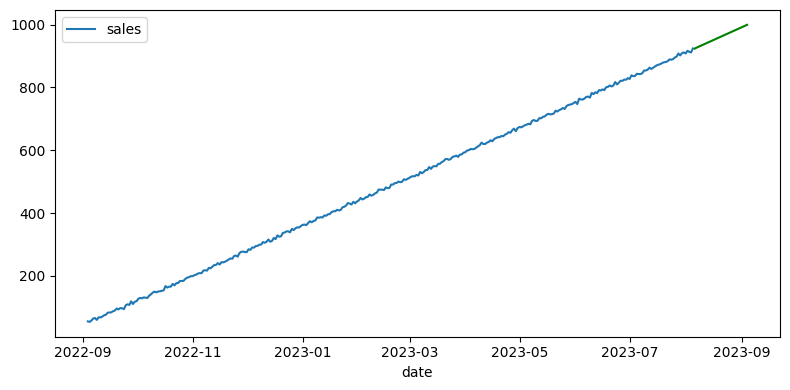

In [90]:
fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = train)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()